# Проект: Обучение с учителем: качество модели

**Описание проекта** 

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. 

Цель проекта: на основе анализа данных и бизнес-моделирования разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Задача:**
- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
- Нужно собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Импорт библиотек**

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install shap -q

In [2]:
import re
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from phik import resources, phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Шаг 1. Загрузка данных

In [4]:
market_file = pd.read_csv('...csv')
market_money = pd.read_csv('...csv')
market_time = pd.read_csv('...csv')
money = pd.read_csv('...csv', sep = ';', decimal = ',')

In [5]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Данные в таблицах соответствуют описанию.

## Шаг 2. Предобработка данных

    1. market_file

In [9]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [10]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Пропусков не обнаружено, типы столбцов корректны.

Проверим наличие явных дубликатов

In [11]:
len(market_file)

1300

In [12]:
market_file = market_file.drop_duplicates().reset_index(drop = True)
len(market_file)

1300

Проверим категориальные признаки на неявные дубликаты

In [13]:
market_file['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [14]:
market_file['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [15]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт','стандарт')
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [16]:
market_file['Разрешить сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [17]:
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

    2. market_money

In [18]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [19]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [20]:
len(market_money)

3900

In [21]:
market_money = market_money.drop_duplicates().reset_index(drop = True)
len(market_money)

3900

In [22]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

    3. market_time

In [23]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [24]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [25]:
len(market_time)

2600

In [26]:
market_time = market_time.drop_duplicates().reset_index(drop = True)
len(market_time)

2600

In [27]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [28]:
#исправим опечатку в данных
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц','предыдущий_месяц')
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

    4. money

In [29]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


На данном этапе была проведена предобработка данных. Удалены неявные дубликаты, типы данных столбцов были в норме, пропуски не обнаружены, исправлены опечатки

In [30]:
market_file.columns = [re.sub(r'\s+', '_', re.sub(r'(?<!^)(?=[A-Z])', '_', i)).lower() for i in market_file.columns]
market_money.columns = [re.sub(r'\s+', '_', re.sub(r'(?<!^)(?=[A-Z])', '_', i)).lower() for i in market_money.columns]
market_time.columns = [re.sub(r'\s+', '_', re.sub(r'(?<!^)(?=[A-Z])', '_', i)).lower() for i in market_time.columns]
money.columns = [re.sub(r'\s+', '_', re.sub(r'(?<!^)(?=[A-Z])', '_', i)).lower() for i in money.columns]
print (market_file.columns, '\n', market_money.columns,'\n', market_time.columns,'\n', money.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object') 
 Index(['id', 'период', 'выручка'], dtype='object') 
 Index(['id', 'период', 'минут'], dtype='object') 
 Index(['id', 'прибыль'], dtype='object')


## Шаг 3. Исследовательский анализ данных

In [31]:
print(market_money.shape)
print(market_file.shape)
print(market_time.shape)
print(money.shape)

(3900, 3)
(1300, 13)
(2600, 3)
(1300, 2)


In [32]:
#отберём покупателей, которые совершали покупки за последние три месяца
id_clients = market_money.loc[market_money['выручка'] == 0, 'id'].unique()
money = money[~money['id'].isin(id_clients)]
market_money = market_money.loc[~market_money['id'].isin(id_clients), :]
market_file = market_file.loc[~market_file['id'].isin(id_clients), :]
market_time = market_time.loc[~market_time['id'].isin(id_clients), :]

In [33]:
print(market_money.shape)
print(market_file.shape)
print(market_time.shape)
print(money.shape)

(3891, 3)
(1297, 13)
(2594, 3)
(1297, 2)


In [34]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000


In [35]:
def plot_hist_boxpl(df):
    
    #выбор числовых столбцов
    numeric_cols = df.select_dtypes(include=['number']).columns

    #установка размера фигуры
    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 5 * num_plots))

    #построение гистограмм и диаграмм размаха для каждого числового столбца
    for i, col in enumerate(numeric_cols):
        #гистограмма
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15, color='pink', edgecolor='black')
        plt.title(f'Гистограмма {col}', fontsize=10)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        
        #диаграмма размаха
        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
        plt.title(f'Диаграмма размаха {col}', fontsize=10)

    #корректировка компоновки
    plt.tight_layout()
    plt.show()

In [36]:
#чтобы id не учитывалось в анализе - сделаем его индексом
market_file = market_file.set_index('id')
market_money = market_money.set_index('id')
market_time = market_time.set_index('id')
money = money.set_index('id')

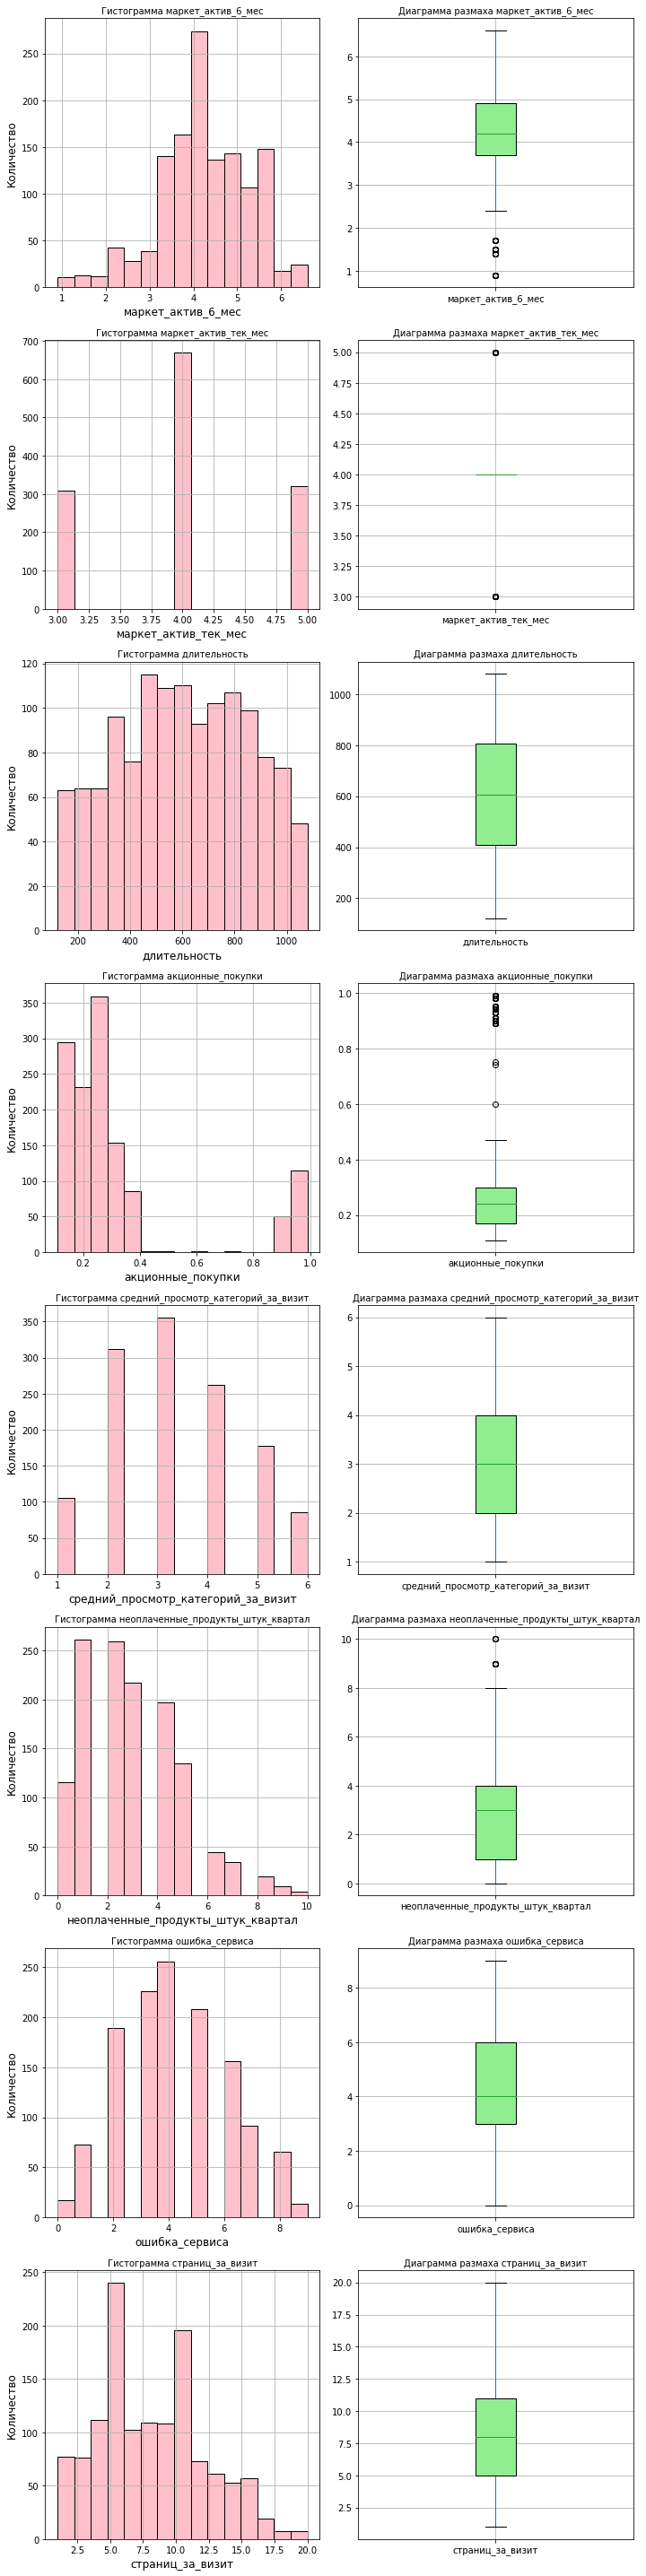

In [37]:
plot_hist_boxpl(market_file)

Гистограмма для параметра Маркет_актив_6_мес имеет ярковыраженные пики, но распределение носит нормальный характер

Гистограмма для параметра Маркет_актив_тек_мес представляет из себя 3 пика, так как это и есть количество уникальных значений.

Гистограмма для параметра Длительность иммет отдаленное сходство с нормальным распределением, в основном большее количество покупателей зарегистрировались на сайте достаточно давно

Гистограмма для параметра Акционные_покупки имеет выброс в районе 1, при медианном значении в районе 0,2.

Диаграмма для параметра Средний_просмотр_категорий_за_визит носит нормальный характер, 

Распределение для параметра Неоплаченные_продукты_штук_квартал носит нормальный характер, правостороннее

Диаграмма для параметра Ошибка_сервиса — носит нормальный характер

Диаграмма Страниц_за_визит имеет 2 пика - 5 и 11 - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

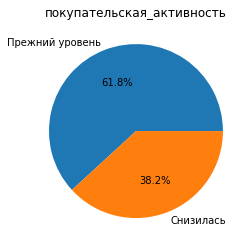

In [38]:
market_file['покупательская_активность'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('покупательская_активность')
plt.ylabel('')
plt.show()

В 38,2% покупательская способность снизилась, но в большем проценте - 61,8% - осталась на прежнем уровне

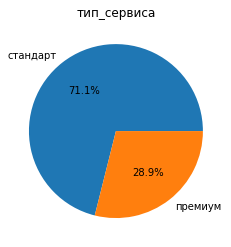

In [39]:
market_file['тип_сервиса'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('тип_сервиса')
plt.ylabel('')
plt.show()

28,9% покупателей имеют уровень "премиум"

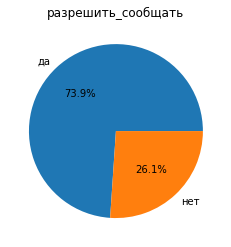

In [40]:
market_file['разрешить_сообщать'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('разрешить_сообщать')
plt.ylabel('')
plt.show()

74% покупателей согласны на письма с предложениями о товаре.

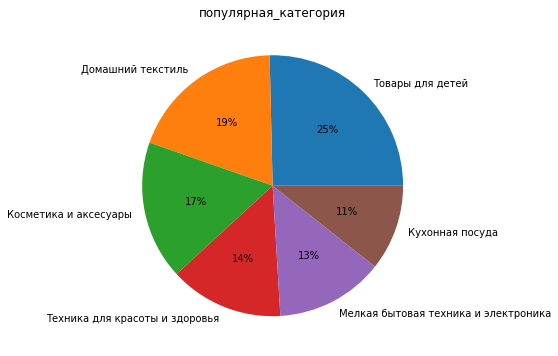

In [41]:
ax = market_file['популярная_категория'].value_counts().plot(
    kind='pie', 
    autopct='%1.0f%%', 
    title='популярная_категория', 
    figsize=(14, 6)
)
ax.set_ylabel('') 
plt.show()


Все категории имеют немаленький процент вовлеченности покупателей, самая популярная категория - Товары для детей (25%) , самая непопулярная - Кухонная посуда(11%). 

In [42]:
market_money.describe()

,выручка
count,3891.000000
mean,5033.718890
std,1768.471286
min,2758.700000
25%,4592.000000
50%,4959.000000
75%,5363.200000
max,106862.200000


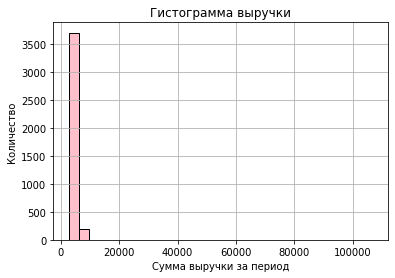

In [43]:
market_money['выручка'].hist(bins=30, color='pink', edgecolor='black')
plt.title('Гистограмма выручки')
plt.xlabel('Cумма выручки за период')
plt.ylabel('Количество')
plt.show()

Присутствуют выбросы, посмотрим на них, при необходимости удалим

In [44]:
market_money.sort_values(by='выручка', ascending=False).head()

,период,выручка
id,,
215380,текущий_месяц,106862.2
215493,текущий_месяц,7799.4
215435,текущий_месяц,7605.3
215841,текущий_месяц,7557.0
216144,текущий_месяц,7547.8


In [45]:
market_money = market_money[market_money['выручка'] != 106862.2]

Построим гистограмму еще раз 

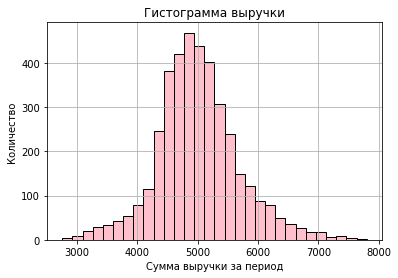

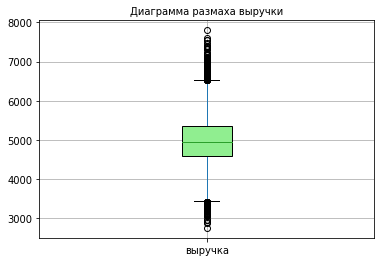

In [46]:
market_money['выручка'].hist(bins=30, color='pink', edgecolor='black')
plt.title('Гистограмма выручки')
plt.xlabel('Cумма выручки за период')
plt.ylabel('Количество')
plt.show()


market_money.boxplot(column='выручка', patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Диаграмма размаха выручки', fontsize=10)
plt.show()

Гистограмма имеет нормальное распределение, медианное значение чуть менее 5000. 

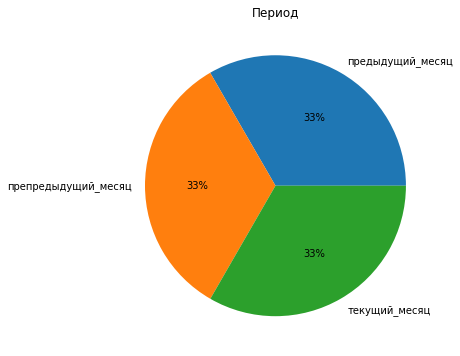

In [47]:
ax = market_money['период'].value_counts().plot(
    kind='pie', 
    autopct='%1.0f%%', 
    title='Период', 
    figsize=(14, 6)
)
ax.set_ylabel('') 
plt.show()


Выручка зафиксирована в трех периодах в равных процентах

In [48]:
market_time.describe()

,минут
count,2594.000000
mean,13.340401
std,4.081999
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


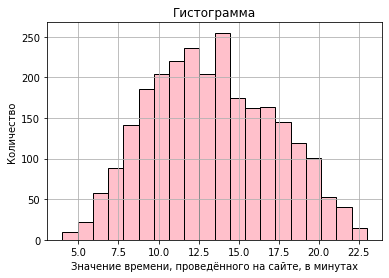

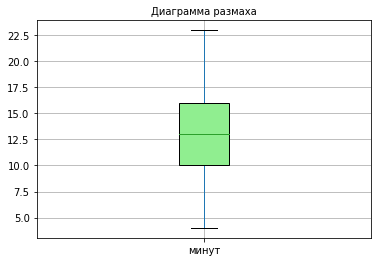

In [49]:
market_time['минут'].hist(bins=20, color='pink', edgecolor='black')
plt.title('Гистограмма')
plt.xlabel('Значение времени, проведённого на сайте, в минутах')
plt.ylabel('Количество')
plt.show()

market_time.boxplot(column='минут', patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Диаграмма размаха', fontsize=10)
plt.show()

Гистограмма имеет нормальный характер распределения, медианное значение в районе 13 минут. 

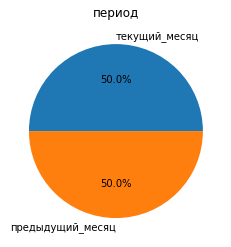

In [50]:
market_time['период'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('период')
plt.ylabel('')
plt.show()

Общее время зафиксровано в двух периодах в равном проценте. 

In [51]:
money.describe()

,прибыль
count,1297.000000
mean,3.997610
std,1.010813
min,0.860000
25%,3.300000
50%,4.040000
75%,4.670000
max,7.430000


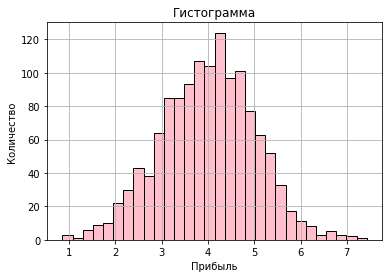

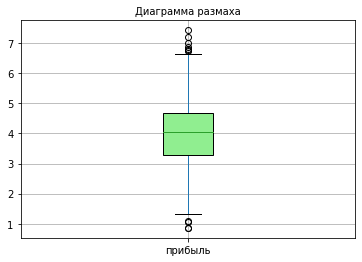

In [52]:
money['прибыль'].hist(bins=30, color='pink', edgecolor='black')
plt.title('Гистограмма')
plt.xlabel('Прибыль')
plt.ylabel('Количество')
plt.show()

money.boxplot(column='прибыль', patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Диаграмма размаха', fontsize=10)
plt.show()

Гистограмма прибыли имеет нормальный характер распределения

## Шаг 4. Объединение таблиц

- 4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся.
- 4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [58]:
market_money.head()

,период,выручка
id,,
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6
215349,предыдущий_месяц,5216.0
215350,препредыдущий_месяц,4826.0
215350,текущий_месяц,5058.4


In [59]:
df_1 = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='first').reset_index()
df_1.columns.name = None 
df_1 = df_1.rename(columns={'id': 'id', 'предыдущий_месяц': 'выручка_предыдущий_месяц', 'препредыдущий_месяц': 'выручка_препредыдущий_месяц', 'текущий_месяц': 'выручка_текущий_месяц'})

In [60]:
df_1.head()

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [61]:
market_time.head()

,период,минут
id,,
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13
215350,предыдущий_месяц,8
215351,текущий_месяц,13


In [62]:
df_2 = market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='first').reset_index()
df_2.columns.name = None
df_2 = df_2.rename(columns={'id': 'id', 'предыдущий_месяц': 'минуты_предыдущий_месяц', 'текущий_месяц': 'минуты_текущий_месяц'})

In [63]:
df_2.head()

,id,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


In [64]:
print(market_file.index)
print(df_1.index)
print(df_2.index)

Int64Index([215349, 215350, 215351, 215352, 215353, 215354, 215355, 215356,
            215358, 215360,
            ...
            216638, 216639, 216640, 216641, 216642, 216643, 216644, 216645,
            216646, 216647],
           dtype='int64', name='id', length=1297)
RangeIndex(start=0, stop=1297, step=1)
RangeIndex(start=0, stop=1297, step=1)


In [65]:
df_1 = df_1.set_index('id')
df_2 = df_2.set_index('id')

In [66]:
df_full = market_file.join(df_1, on='id')
df_full = df_full.join(df_2, on='id')

In [67]:
df_full.head(20)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10


In [68]:
df_full.shape

(1297, 17)

In [69]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1297 non-null   object 
 1   тип_сервиса                          1297 non-null   object 
 2   разрешить_сообщать                   1297 non-null   object 
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   object 
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит       

In [70]:
df_full.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1296.000000,1297.000000,1297.000000
mean,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,4948.339630,4836.367772,5238.096065,13.469545,13.211257
std,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,701.228571,333.438742,834.318717,3.936323,4.220222
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.500000,4585.000000,4706.050000,11.000000,10.000000
50%,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4812.000000,5179.950000,13.000000,13.000000
75%,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,5409.000000,5055.000000,5759.275000,17.000000,16.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


In [71]:
#посмотрим на строку с пропущенным значением в "выручка_текущий_месяц"
df_full[df_full.isnull().any(axis=1)]

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
id,,,,,,,,,,,,,,,,,
215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,6077.0,5051.0,NaN,12,14


In [73]:
#удалим строку с NaN 
df_full = df_full.dropna(how='any')

In [74]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

Таблицы объединены, типы данных корректны

## Шаг 5. Корреляционный анализ

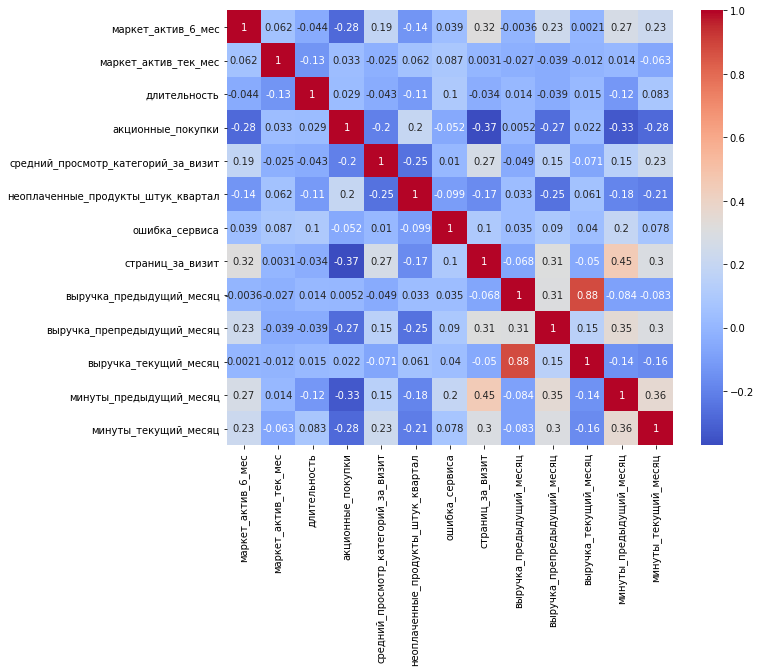

In [75]:
numeric_cols = df_full.select_dtypes(include=['number']).columns
correlation_matrix = df_full[numeric_cols].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [76]:
df_full.phik_matrix().style.background_gradient(cmap ='coolwarm')

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц']


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.224638,0.497393,0.197213,0.685138,0.576770
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.000000,0.069704,0.124216,0.131814,0.000000
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.080842,0.000000,0.060907,0.038387,0.000000
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.155476,0.315331,0.039795,0.363950,0.330601
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.125572,0.113200,0.147048,0.026448,0.101481
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.060733,0.226381,0.071094,0.262324,0.250558
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.252097,0.043528,0.237240,0.195233,0.089883
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.098440,0.176828,0.092597,0.159837,0.182568
неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.249171,0.261016,0.230022,0.256632,0.232383


Cильная корреляция (выше 0.8) в данной матрице наблюдается только между выручкой за текущий месяц и предыдущий, это может указывать на то, что данные за текущий и предыдущий месяцы имеют схожие или зависимые тенденции, может привести к мультиколлинеарности в модели регрессии, но необходимости удалять одну переменную или использования разностей пока что нет. 

## Шаг 6. Использование пайплайнов

In [77]:
df_full['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [80]:
#определяем классы: "Снизилась" должна быть закодирована как 1
original_classes = ['Прежний уровень', 'Снизилась']

#создаем кастомный LabelEncoder и устанавливаем его классы
le_custom = LabelEncoder()
le_custom.classes_ = np.array(original_classes)

#кодируем целевую переменную
y = le_custom.transform(df_full['покупательская_активность'])

#разделение данных на обучающую и тестовую выборки
X = df_full.drop(['покупательская_активность'], axis=1)

print("Классы закодированы так:")
print(dict(zip(original_classes, le_custom.transform(original_classes))))

Классы закодированы так:
{'Прежний уровень': 0, 'Снизилась': 1}


In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)

In [82]:
print(X_train.columns)

Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
       'популярная_категория', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минуты_предыдущий_месяц', 'минуты_текущий_месяц'],
      dtype='object')


In [83]:
#определение колонок для обработки
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 
               'выручка_текущий_месяц', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц']

In [84]:
start_time = time.time()

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('categorical_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns),
        ('ordinal', OrdinalEncoder(), ord_columns),
        ('scaler', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

#итоговый пайплайн объединяет обработку данных и модель
full_pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessing_pipeline),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

#словарь гиперпараметров для RandomizedSearchCV
hyperparameter_space = [
    #параметры для дерева решений (менее оптимизированные)
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': np.arange(2, 4),  
        'model__max_features': np.arange(2, 4)  
    },
    #параметры для KNeighborsClassifier 
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': np.arange(5, 21)  
    },
    #параметры для LogisticRegression 
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
        'model__penalty': ['l2'], 
        'model__solver': ['newton-cg', 'lbfgs', 'saga']  
    },
    #параметры для SVC 
    {
        'model': [SVC(probability=True)],
        'model__kernel': ['linear'],
        'model__C': [0.01, 1, 100]
    }
]

#cоздание и запуск RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=hyperparameter_space,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1 
)
search.fit(X_train, y_train)

#вывод лучших результатов
print('Наилучшая модель и её параметры:\n', search.best_estimator_)
print('ROC-AUC для лучшей модели на кросс-валидационных данных:', search.best_score_)

#проверка модели на тестовых данных
y_test_probabilities = search.predict_proba(X_test)
roc_auc_test = roc_auc_score(y_test, y_test_probabilities[:, 1])
print(f'ROC-AUC метрика на тестовой выборке: {roc_auc_test}')


Наилучшая модель и её параметры:
 Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['тип_сервиса']),
                                                 ('scaler', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                             

В коде используется метрика ROC-AUC для оценки производительности модели. ROC-AUC оценивает производительность модели на различных порогах классификации, что позволяет получить более полное представление о её способности к различению классов. ROC-AUC учитывает как ложные срабатывания (False Positives), так и пропущенные положительные случаи (False Negatives), что делает её полезной в задачах с несбалансированными классами.

## Шаг 7. Анализ важности признаков

In [85]:
shap.initjs()


X_train_shap = pd.DataFrame(
    search.best_estimator_.named_steps['preprocessing'].transform(X_train), 
    columns=search.best_estimator_.named_steps['preprocessing'].get_feature_names_out()
)

X_test_shap = pd.DataFrame(
    search.best_estimator_.named_steps['preprocessing'].transform(X_test), 
    columns=search.best_estimator_.named_steps['preprocessing'].get_feature_names_out()
)


explainer = shap.LinearExplainer(
    search.best_estimator_.named_steps['model'],
    X_train_shap
)


shap_values = explainer.shap_values(X_test_shap)


shap_obj = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_shap
)

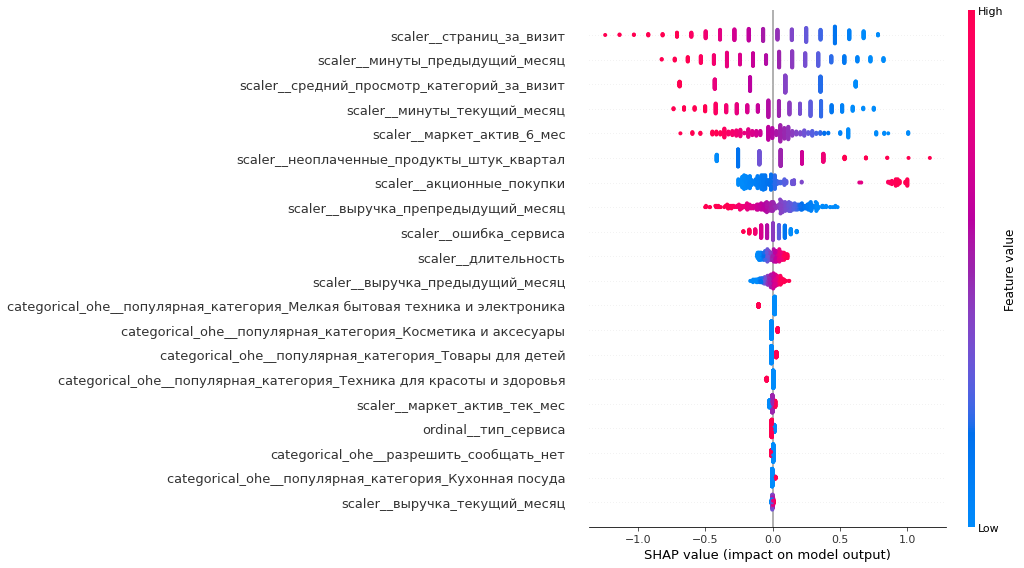

In [86]:
shap.plots.beeswarm(shap_obj, max_display=21)

/opt/conda/lib/python3.9/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  pl.tight_layout()


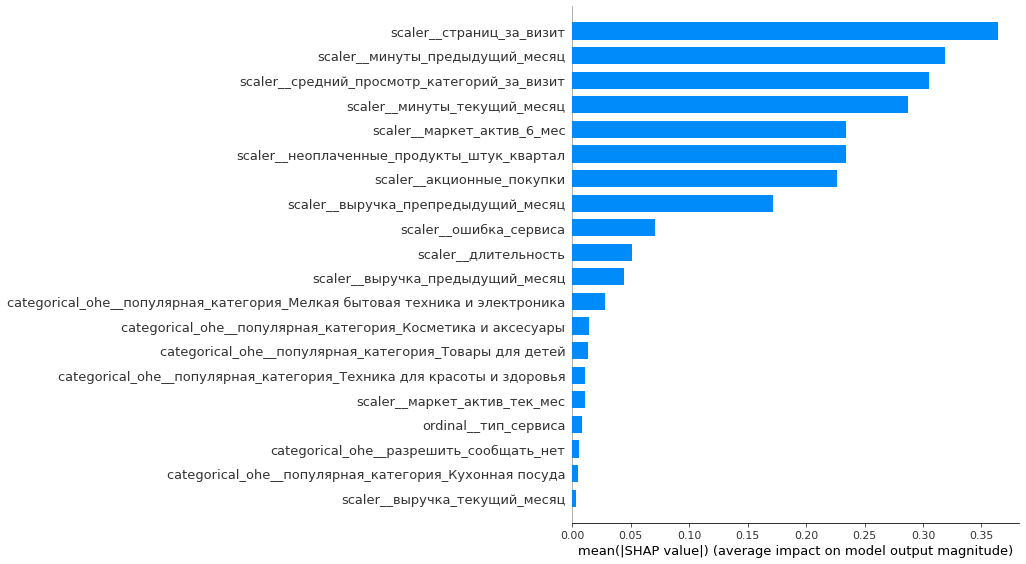

In [87]:
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")

Самый большой вес у признака "страниц за визит", он сильнее всего влияет на прогнозы модели. Так как "1" в нашем коде закодирован класс покупательской активности "Снизилась", то чем больше значения признаков "страниц за визит", "минуты предыдущий месяц"и "средний просмотр категорий за визит", тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 0 - покупательская активность на прежнем уровне. При акционных продажах наблюдаем справа красный цвет, указывающий на повышенную вероятность снижения покупательской активности.

## Шаг 8. Сегментация покупателей

In [91]:
#предсказание вероятностей
predicted = search.best_estimator_.predict_proba(X_test)[:, 1]

#добавление столбца 'predicted' в X_test
X_test['predicted'] = predicted

X_test.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,predicted
id,,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0.050826
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,0.937825
216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0.179681
215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,0.646896
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.531322


In [92]:
print("Столбцы в X_test:")
print(X_test.columns)

print("Столбцы в money:")
print(money.columns)

Столбцы в X_test:
Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
       'популярная_категория', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'predicted'],
      dtype='object')
Столбцы в money:
Index(['прибыль'], dtype='object')


In [93]:
money.head()

,прибыль
id,
215349,4.16
215350,3.13
215351,4.87
215352,4.21
215353,3.95


In [94]:
#сбросим индекс в таблице money, чтобы id стал обычным столбцом
money_reset = money.reset_index()

#объединим таблицы по индексу используя join
segment = X_test.join(money_reset.set_index('id'), on='id')
segment.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,predicted,прибыль
id,,,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0.050826,4.69
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,0.937825,2.75
216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0.179681,3.16
215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,0.646896,3.74
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.531322,4.40


In [95]:
#вычисление средней прибыли
mean_profit = segment['прибыль'].mean()

#создание целевого сегмента
target_segment = segment[(segment['predicted'] >= 0.6) & (segment['прибыль'] >= mean_profit)]

#создание контрсегмента
contrast_segment = segment[(segment['predicted'] < 0.6) & (segment['прибыль'] >= mean_profit)]

#проверка наличия данных после фильтрации
print(f"Количество записей в целевом сегменте: {len(target_segment)}")
print(f"Количество записей в контрсегменте: {len(contrast_segment)}")

Количество записей в целевом сегменте: 56
Количество записей в контрсегменте: 115


In [96]:
#сравнение средних значений признаков
mean_target_segment = target_segment.mean()
mean_contrast_segment = contrast_segment.mean()

comparison = pd.DataFrame({
    'Целевой сегмент': mean_target_segment,
    'Контрсегмент': mean_contrast_segment
}).T

# Вывод сравнения
print("Сравнение средних значений признаков между целевым и контрсегментом:")

comparison.style.format("{:.2f}").set_caption("Средние значения признаков")

Сравнение средних значений признаков между целевым и контрсегментом:


,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,predicted,прибыль
Целевой сегмент,3.41,4.04,624.50,0.53,2.61,4.09,3.79,3.84,5069.88,4621.75,5355.43,9.48,9.82,0.81,4.70
Контрсегмент,4.51,4.01,585.82,0.24,3.68,2.34,4.37,9.71,4809.10,4878.57,5128.73,14.72,14.70,0.22,4.63


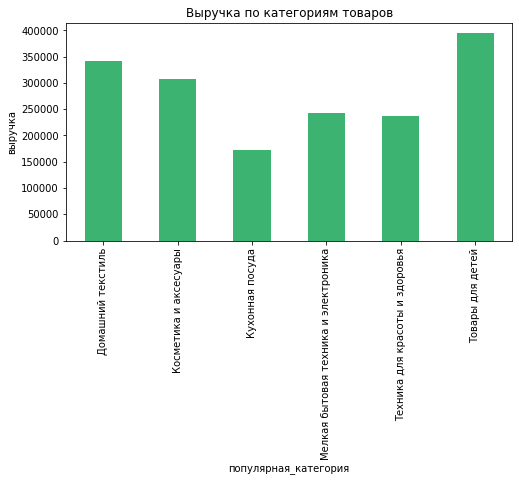

In [97]:
#динамика выручки по категориям товаров
revenue_by_category = segment.groupby('популярная_категория')['выручка_текущий_месяц'].sum()
revenue_by_category.plot(kind='bar', color='mediumseagreen', figsize=(8, 4), legend=False, title='Выручка по категориям товаров')
plt.ylabel('выручка')
plt.show()

На основе результатов моделирования и данных о прибыльности покупателей были выделены два сегмента:  сегмент клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью, в качестве контрастигмента такие же выгодные клиенты но для которых модель предсказывает высокую вероятность сохранения активности(<0,6). 

- Целевой сегмент:

Характеризуется высокой предсказанной вероятностью (0.90) и высокой выручкой в текущем месяце.
Менее активен в акциях, чем контрсегмент, но более активен по другим показателям.

- Контрсегмент:

Меньше активен в акциях, но имеет большее количество страниц за визит и большее среднее время на сайте.
Низкая предсказанная вероятность (0.15), что может указывать на потенциальное снижение покупательской активности.

Больше всего выручки приносят категории товаров - "Товары для детей" и "Домашний текстиль".

Предложения по работе с сегментом для увеличения покупательской активности:
- Увеличение акционных предложений: Поскольку акционные покупки в контрсегменте низкие, это может стать фактором для увеличения активности.
- Оптимизация сайта: Улучшение интерфейса и пользовательского опыта для контрсегмента, который проводит больше времени на сайте, может стимулировать покупки.
- Персонализированные рекомендации: Внедрение персонализированных предложений может повысить покупательскую активность в обоих сегментах.
- Работа с неоплаченными продуктами: Улучшение процесса оплаты и напоминаний может помочь уменьшить количество неоплаченных продуктов и увеличить общие продажи.

## Шаг 9. Общий вывод

В ходе проекта была построена модель, которая предсказывает вероятность снижения покупательской активности клиента в следующие три месяца. Используя данные модели и данные о прибыльности клиентов, выделен сегмент покупателей и разработаны для них персонализированные предложения: стоит акцентировать внимание пользователей на акционные товары в самых просматриваемых категориях. Средний просмотр категорий за визит также является важным показателем. Компании рекомендуется сосредоточиться и на этом факторе, исследовать пользовательское поведение и использовать результаты анализа для создания персонализированных предложений.

Для поиска наилучшей модели были выполнены следующие этапы:

- Анализ данных: Изучены исходные данные.
- Очистка данных: Обработаны пропуски и дубликаты.
- Оценка качества данных: Проверены данные на наличие выбросов и аномалий.
- Корреляционный анализ: Исследованы взаимосвязи между количественными признаками.
- Обогащение данных: Объединены данные для увеличения числа признаков, доступных для обучения модели.
- Автоматизация обучения: Настроены пайплайны для автоматизации процесса обучения, в которых протестированы два типа моделей: линейные и основанные на векторах.
- Выбор лучшей модели: Наилучшей моделью оказалась LogisticRegression.

Предложения по работе с сегментом для увеличения покупательской активности:
- Увеличение акционных предложений: Поскольку акционные покупки в контрсегменте низкие, это может стать фактором для увеличения активности.
- Оптимизация сайта: Улучшение интерфейса и пользовательского опыта для контрсегмента, который проводит больше времени на сайте, может стимулировать покупки.
- Персонализированные рекомендации: Внедрение персонализированных предложений может повысить покупательскую активность в обоих сегментах.
- Работа с неоплаченными продуктами: Улучшение процесса оплаты и напоминаний может помочь уменьшить количество неоплаченных продуктов и увеличить общие продажи.
